Based on modeling done in "New Stats - Modeling", I am making some changes to the features in my model.  These are summarized in that notebook, and the new baseball savant page is in the below:

https://baseballsavant.mlb.com/leaderboard/custom?year=2020,2019,2018,2017,2016,2015&type=batter&filter=&sort=16&sortDir=desc&min=200&selections=player_age,b_total_pa,b_bb_percent,b_game,exit_velocity_avg,launch_angle_avg,barrel_batted_rate,solidcontact_percent,flareburner_percent,poorlyunder_percent,poorlytopped_percent,poorlyweak_percent,z_swing_percent,oz_swing_percent,iz_contact_percent,whiff_percent,pull_percent,straightaway_percent,opposite_percent,f_strike_percent,sprint_speed,&chart=false&x=player_age&y=player_age&r=no&chartType=beeswarm

Import needed packages:

In [116]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
from IPython.core.display import display, HTML    # make sure Jupyter knows to display it as HTML
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import unicodedata
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Importing the functions I need to build the new dataframe:

In [117]:
from baseball_savant_code import *
from fangraphs_wrc_code import *

Add in the urls:

In [118]:
savant_url = 'https://baseballsavant.mlb.com/leaderboard/custom?year=2020,2019,2018,2017,2016,2015&type=batter&filter=&sort=16&sortDir=desc&min=200&selections=player_age,b_total_pa,b_k_percent,b_bb_percent,b_game,exit_velocity_avg,launch_angle_avg,barrel_batted_rate,solidcontact_percent,flareburner_percent,poorlyunder_percent,poorlytopped_percent,poorlyweak_percent,z_swing_percent,oz_swing_percent,iz_contact_percent,whiff_percent,pull_percent,straightaway_percent,opposite_percent,f_strike_percent,sprint_speed,&chart=false&x=player_age&y=player_age&r=no&chartType=beeswarm'
fg_url = 'https://www.fangraphs.com/leaders/season-stat-grid?position=B&seasonStart=2015&seasonEnd=2020&stat=wRC%2B&pastMinPt=200&curMinPt=0&mode=normal'

Create new dataframes:

In [119]:
savant_df = Savant_DataFrame_Builder(savant_url)

In [121]:
fg_df = wRC_DataFrame_Shifter(fg_url)

In [122]:
savant_df.head()

Player   Year  Age    PA     K%   BB%     G Avg EV (MPH)  \
Rk.                                                                       
1     Alberto, Hanser   2020   28   231   13.0   2.2    54         82.3   
2       Alfaro, Jorge   2019   26   465   33.1   4.7   130         90.8   
3     Sandoval, Pablo   2015   29   505   14.5   5.0   126         88.1   
4       Pillar, Kevin   2019   30   645   13.8   2.8   161         86.4   
5         Hicks, John   2019   30   333   32.7   3.9    95         87.9   

    Avg LA (°) Barrel%  ... Zone Swing % Out of Zone Swing %  \
Rk.                     ...                                    
1         13.2     1.0  ...         74.2                51.3   
2          4.7    11.5  ...         79.6                48.1   
3           10     4.8  ...         74.5                47.0   
4         14.1     4.9  ...         73.0                46.9   
5         16.2     6.6  ...         78.4                45.9   

    In Zone Contact % Whiff % Pull % Straight Away % Oppo % First Strike %  \
Rk.                                                                          
1                88.7    17.1   35.8            40.4   23.8           64.1   
2                72.8    38.4   27.6            40.9   31.5           63.2   
3                84.6    19.2   30.0            41.0   29.0           65.0   
4                90.9    17.8   45.2            32.1   22.7           64.5   
5                73.5    35.7   42.7            37.0   20.4           71.2   

    Sprint Speed              Player Link  
Rk.                                        
1           26.8  [/savant-player/593643]  
2           28.8  [/savant-player/595751]  
3           24.7  [/savant-player/467055]  
4           28.0  [/savant-player/607680]  
5           26.6  [/savant-player/543308]  

[5 rows x 25 columns]

In [123]:
fg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5046 entries, 0 to 5045
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name-Year  5046 non-null   object
 1   wRC+       5046 non-null   object
dtypes: object(2)
memory usage: 79.0+ KB


## Merge The DF's
*Note: this code is originally from Project_2_Savant notebook, moving here to clean up the workflow.*

In [124]:
fg_df.rename(columns={'Name-Year':'Player_Year_ID'}, inplace=True)

In [125]:
fg_df.head(2)

Player_Year_ID wRC+
0  Michael Lorenzen-2015    0
1  Michael Lorenzen-2016    0

Function to strip accent marks from names so they can all be mapped to the savant data:

In [126]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

In [127]:
player_list = fg_df.Player_Year_ID.to_list()

In [128]:
updated_names = [strip_accents(name).replace('?','e') for name in player_list]

In [129]:
updated_names

['Michael Lorenzen-2015',
 'Michael Lorenzen-2016',
 'Michael Lorenzen-2017',
 'Michael Lorenzen-2018',
 'Michael Lorenzen-2019',
 'Michael Lorenzen-2020',
 'Luis Campusano-2015',
 'Luis Campusano-2016',
 'Luis Campusano-2017',
 'Luis Campusano-2018',
 'Luis Campusano-2019',
 'Luis Campusano-2020',
 'Billy McKinney-2015',
 'Billy McKinney-2016',
 'Billy McKinney-2017',
 'Billy McKinney-2018',
 'Billy McKinney-2019',
 'Billy McKinney-2020',
 'Rafael Marchan-2015',
 'Rafael Marchan-2016',
 'Rafael Marchan-2017',
 'Rafael Marchan-2018',
 'Rafael Marchan-2019',
 'Rafael Marchan-2020',
 'Travis Blankenhorn-2015',
 'Travis Blankenhorn-2016',
 'Travis Blankenhorn-2017',
 'Travis Blankenhorn-2018',
 'Travis Blankenhorn-2019',
 'Travis Blankenhorn-2020',
 'Yolmer Sanchez-2015',
 'Yolmer Sanchez-2016',
 'Yolmer Sanchez-2017',
 'Yolmer Sanchez-2018',
 'Yolmer Sanchez-2019',
 'Yolmer Sanchez-2020',
 'Andrew Stevenson-2015',
 'Andrew Stevenson-2016',
 'Andrew Stevenson-2017',
 'Andrew Stevenson-201

In [130]:
fg_df.Player_Year_ID = updated_names

Back to Baseball Savant:

In [131]:
player_list = savant_df.Player.tolist()

In [132]:
player_list_split = [player.split(', ') for player in player_list]
for player in player_list_split:
    player[0] = player[0].strip()

final_player_list = [(player[1] + ' ' + player[0]) for player in player_list_split]    

In [133]:
print(final_player_list)

['Hanser Alberto', 'Jorge Alfaro', 'Pablo Sandoval', 'Kevin Pillar', 'John Hicks', 'Salvador Perez', 'Francisco Mejia', 'Jose Iglesias', 'Dawel Lugo', 'Hanser Alberto', 'Ronny Rodriguez', 'Salvador Perez', 'Victor Reyes', 'Jeff Francoeur', 'Eddie Rosario', 'Adam Jones', 'Tim Anderson', 'Jorge Alfaro', 'A.J. Pierzynski', 'Jeff Francoeur', 'Javier Baez', 'Eddie Rosario', 'Corey Dickerson', 'Javier Baez', 'Corey Dickerson', 'Avisail Garcia', 'Salvador Perez', 'Adam Jones', 'Jonathan Schoop', 'Javier Baez', 'Christian Bethancourt', 'Jimmy Paredes', 'Jonathan Schoop', 'Marlon Byrd', 'Corey Dickerson', 'Salvador Perez', 'Kevin Pillar', 'Victor Reyes', 'Eddie Rosario', 'Adam Jones', 'Adeiny Hechavarria', 'Jonathan Schoop', 'Harold Castro', 'Rougned Odor', 'Pablo Sandoval', 'Lonnie Chisenhall', 'Scooter Gennett', 'Javier Baez', 'Corey Dickerson', 'Raimel Tapia', 'Hernan Perez', 'Brandon Phillips', 'Hernan Perez', 'Corey Dickerson', 'Harold Ramirez', 'Avisail Garcia', 'Gio Urshela', 'Eddie Rosa

In [134]:
year_list = savant_df.Year.tolist()

In [135]:
year_list = [int(year) for year in year_list]
print(year_list)

[2020, 2019, 2015, 2019, 2019, 2017, 2019, 2019, 2019, 2019, 2019, 2018, 2018, 2016, 2015, 2015, 2019, 2018, 2016, 2015, 2018, 2019, 2019, 2017, 2017, 2015, 2016, 2016, 2015, 2019, 2016, 2015, 2016, 2015, 2018, 2015, 2018, 2020, 2018, 2017, 2017, 2019, 2019, 2016, 2017, 2016, 2015, 2016, 2016, 2019, 2015, 2016, 2016, 2015, 2019, 2018, 2019, 2016, 2020, 2016, 2017, 2015, 2019, 2015, 2020, 2018, 2018, 2020, 2017, 2017, 2020, 2018, 2015, 2019, 2017, 2017, 2015, 2019, 2018, 2018, 2017, 2015, 2019, 2015, 2018, 2016, 2015, 2017, 2019, 2016, 2020, 2019, 2019, 2015, 2015, 2020, 2017, 2016, 2016, 2015, 2015, 2015, 2019, 2018, 2017, 2015, 2019, 2019, 2019, 2018, 2016, 2015, 2020, 2019, 2019, 2019, 2017, 2017, 2016, 2018, 2018, 2017, 2016, 2015, 2019, 2019, 2019, 2017, 2016, 2016, 2016, 2019, 2018, 2016, 2016, 2018, 2019, 2018, 2016, 2016, 2015, 2019, 2019, 2017, 2017, 2017, 2019, 2017, 2017, 2016, 2015, 2020, 2018, 2016, 2019, 2018, 2017, 2016, 2015, 2015, 2018, 2015, 2019, 2018, 2018, 2016, 201

In [136]:
player_year_id = []
for i, player in enumerate(final_player_list):
    id_str = player + "-" + str(year_list[i])
    player_year_id.append(id_str)
print(player_year_id)

['Hanser Alberto-2020', 'Jorge Alfaro-2019', 'Pablo Sandoval-2015', 'Kevin Pillar-2019', 'John Hicks-2019', 'Salvador Perez-2017', 'Francisco Mejia-2019', 'Jose Iglesias-2019', 'Dawel Lugo-2019', 'Hanser Alberto-2019', 'Ronny Rodriguez-2019', 'Salvador Perez-2018', 'Victor Reyes-2018', 'Jeff Francoeur-2016', 'Eddie Rosario-2015', 'Adam Jones-2015', 'Tim Anderson-2019', 'Jorge Alfaro-2018', 'A.J. Pierzynski-2016', 'Jeff Francoeur-2015', 'Javier Baez-2018', 'Eddie Rosario-2019', 'Corey Dickerson-2019', 'Javier Baez-2017', 'Corey Dickerson-2017', 'Avisail Garcia-2015', 'Salvador Perez-2016', 'Adam Jones-2016', 'Jonathan Schoop-2015', 'Javier Baez-2019', 'Christian Bethancourt-2016', 'Jimmy Paredes-2015', 'Jonathan Schoop-2016', 'Marlon Byrd-2015', 'Corey Dickerson-2018', 'Salvador Perez-2015', 'Kevin Pillar-2018', 'Victor Reyes-2020', 'Eddie Rosario-2018', 'Adam Jones-2017', 'Adeiny Hechavarria-2017', 'Jonathan Schoop-2019', 'Harold Castro-2019', 'Rougned Odor-2016', 'Pablo Sandoval-2017'

In [137]:
savant_df['Player_Year_ID'] = player_year_id

In [138]:
savant_df.sample(15)

Player   Year  Age    PA     K%    BB%     G Avg EV (MPH)  \
Rk.                                                                             
438    Hechavarria, Adeiny   2016   27   547   13.3    6.0   155         88.1   
1232          Davis, Khris   2015   28   440   27.7   10.0   121         89.8   
341           Suzuki, Kurt   2018   35   388   11.1    5.7   105         87.2   
651         Alonso, Yonder   2018   31   574   21.4    8.9   145         87.8   
1311        Correa, Carlos   2017   23   481   19.1   11.0   109         90.3   
1476          Pagan, Angel   2015   34   551   16.9    5.8   133         86.2   
700     Taylor, Michael A.   2017   26   432   31.7    6.7   118         87.5   
832      Cuthbert, Cheslor   2019   27   330   20.3    5.8    87         88.9   
625       Escobar, Eduardo   2015   26   446   19.3    6.3   127         86.6   
134            Abreu, Jose   2016   29   695   18.0    6.8   159         89.7   
1024        Martinez, J.D.   2017   30   489   26.2   10.8   119           91   
1669     Souza Jr., Steven   2017   28   617   29.0   13.6   148         88.8   
1350        Flowers, Tyler   2017   31   370   22.2    8.4    99         89.4   
1825          Utley, Chase   2017   39   353   16.1    9.1   127         86.8   
691        Sizemore, Grady   2015   33   296   20.3    6.8    97         89.3   

     Avg LA (°) Barrel%  ... Out of Zone Swing % In Zone Contact % Whiff %  \
Rk.                      ...                                                 
438           8     1.1  ...                32.4              89.0    16.2   
1232       12.5    14.7  ...                25.6              74.1    33.1   
341        18.2     3.9  ...                33.7              89.6    16.8   
651        15.7     9.8  ...                30.4              82.2    25.4   
1311        9.1     9.0  ...                24.9              85.4    21.8   
1476       11.5     0.7  ...                23.5              91.8    12.4   
700        12.4     9.8  ...                30.0              74.8    33.5   
832        14.9     4.5  ...                29.0              84.2    24.1   
625        13.9     6.1  ...                30.7              84.4    21.7   
134        10.3     7.9  ...                37.5              85.6    23.8   
1024       15.8    19.2  ...                27.3              74.9    31.2   
1669       11.5    11.5  ...                21.3              75.0    32.1   
1350       11.1     6.3  ...                24.6              79.0    25.6   
1825       10.7     4.3  ...                18.1              90.1    14.1   
691        12.4     4.2  ...                30.1              88.1    21.1   

     Pull % Straight Away % Oppo % First Strike % Sprint Speed  \
Rk.                                                              
438    24.5            42.7   32.7           60.5         27.6   
1232   38.1            41.4   20.5           59.3         26.9   
341    47.7            33.9   18.4           62.1         25.6   
651    39.7            38.4   21.9           57.3         23.3   
1311   25.1            47.0   27.8           56.9         27.7   
1476   30.4            41.4   28.2           56.7         28.2   
700    41.9            35.8   22.3           63.2         28.8   
832    42.6            36.4   21.1           67.6         26.6   
625    37.6            37.9   24.5           59.6         27.4   
134    33.1            37.6   29.3           59.3         25.6   
1024   32.8            37.7   29.5           63.4         27.0   
1669   43.8            36.0   20.2           60.3         28.9   
1350   37.1            35.0   27.8           61.6         25.8   
1825   39.6            35.3   25.1           60.6         27.6   
691    39.3            30.8   29.9           60.5         26.5   

                  Player Link           Player_Year_ID  
Rk.                                                     
438   [/savant-player/588751]  Adeiny Hechavarria-2016  
1232  [/savant-player

Actual merging:

In [139]:
combined_df = savant_df.merge(fg_df, how='left', on='Player_Year_ID')

In [140]:
combined_df

Player   Year  Age    PA     K%    BB%     G Avg EV (MPH)  \
0      Alberto, Hanser   2020   28   231   13.0    2.2    54         82.3   
1        Alfaro, Jorge   2019   26   465   33.1    4.7   130         90.8   
2      Sandoval, Pablo   2015   29   505   14.5    5.0   126         88.1   
3        Pillar, Kevin   2019   30   645   13.8    2.8   161         86.4   
4          Hicks, John   2019   30   333   32.7    3.9    95         87.9   
...                ...    ...  ...   ...    ...    ...   ...          ...   
1888       Avila, Alex   2018   31   234   38.5   15.8    80         89.7   
1889   Forsythe, Logan   2017   30   439   24.8   15.7   119           89   
1890       Avila, Alex   2017   30   376   31.9   16.5   112           91   
1891   Forsythe, Logan   2019   32   367   27.2   12.0   101         89.3   
1892   Martin, Russell   2018   35   352   23.3   15.9    90         90.6   

     Avg LA (°) Barrel%  ... In Zone Contact % Whiff % Pull % Straight Away %  \
0          13.2     1.0  ...              88.7    17.1   35.8            40.4   
1           4.7    11.5  ...              72.8    38.4   27.6            40.9   
2            10     4.8  ...              84.6    19.2   30.0            41.0   
3          14.1     4.9  ...              90.9    17.8   45.2            32.1   
4          16.2     6.6  ...              73.5    35.7   42.7            37.0   
...         ...     ...  ...               ...     ...    ...             ...   
1888        8.6    12.3  ...              69.2    36.3   45.3            34.0   
1889       12.3     3.9  ...              81.6    23.1   27.2            48.2   
1890       12.4    15.0  ...              70.3    36.4   31.6            40.4   
1891       12.3     5.5  ...              82.1    21.3   40.6            36.5   
1892       10.1     6.3  ...              78.9    25.3   37.7            42.0   

     Oppo % First Strike % Sprint Speed              Player Link  \
0      23.8           64.1         26.8  [/savant-player/593643]   
1      31.5           63.2         28.8  [/savant-player/595751]   
2      29.0           65.0         24.7  [/savant-player/467055]   
3      22.7           64.5         28.0  [/savant-player/607680]   
4      20.4           71.2         26.6  [/savant-player/543308]   
...     ...            ...          ...                      ...   
1888   20.8           58.5         23.8  [/savant-player/488671]   
1889   24.5           57.2         27.5  [/savant-player/523253]   
1890   28.0           60.9         25.0  [/savant-player/488671]   
1891   22.8           59.9         27.3  [/savant-player/523253]   
1892   20.3           56.0         25.6  [/savant-player/431145]   

           Player_Year_ID wRC+  
0     Hanser Alberto-2020   87  
1       Jorge Alfaro-2019   95  
2     Pablo Sandoval-2015   76  
3       Kevin Pillar-2019   85  
4         John Hicks-2019   56  
...                   ...  ...  
1888      Alex Avila-2018   67  
1889  Logan Forsythe-2017   90  
1890      Alex Avila-2017  125  
1891  Logan Forsythe-2019   75  
1892  Russell Martin-2018   91  

[1893 rows x 27 columns]

1893 rows as expected.

## Exploring combined DF:

In [141]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Player               1893 non-null   object
 1   Year                 1893 non-null   object
 2   Age                  1893 non-null   object
 3   PA                   1893 non-null   object
 4   K%                   1893 non-null   object
 5   BB%                  1893 non-null   object
 6   G                    1893 non-null   object
 7   Avg EV (MPH)         1893 non-null   object
 8   Avg LA (°)           1893 non-null   object
 9   Barrel%              1893 non-null   object
 10  Solid Contact %      1893 non-null   object
 11  Flare/Burner %       1893 non-null   object
 12  Under %              1893 non-null   object
 13  Topped %             1893 non-null   object
 14  Poor/Weak %          1893 non-null   object
 15  Zone Swing %         1893 non-null   object
 16  Out of

Filling in null values:

In [142]:
combined_df[combined_df['wRC+'].isnull()]

Player   Year  Age    PA     K%    BB%     G Avg EV (MPH)  \
1154   Ramirez, Jose   2016   24   618   10.0    7.1   152         88.4   
1415   Ramirez, Jose   2015   23   355   11.0    9.0    97         86.6   
1517   Ramirez, Jose   2017   25   645   10.7    8.1   152         88.2   
1547   Ramirez, Jose   2019   27   542   13.7    9.6   129         89.2   
1573   Ramirez, Jose   2020   28   254   16.9   12.2    58         88.7   
1764   Ramirez, Jose   2018   26   698   11.5   15.2   157           89   

     Avg LA (°) Barrel%  ... In Zone Contact % Whiff % Pull % Straight Away %  \
1154       13.2     3.0  ...              89.7    12.7   35.6            36.2   
1415         12     1.8  ...              91.1    11.6   40.3            35.0   
1517         15     5.0  ...              90.4    13.6   42.8            34.9   
1547       19.8     6.3  ...              91.1    14.6   48.1            31.2   
1573       23.2    10.2  ...              86.9    16.6   47.5            33.9   
1764         19     8.3  ...              89.8    13.7   47.8            33.9   

     Oppo % First Strike % Sprint Speed              Player Link  \
1154   28.1           57.0         27.9  [/savant-player/608070]   
1415   24.7           58.0         28.0  [/savant-player/608070]   
1517   22.3           56.0         28.0  [/savant-player/608070]   
1547   20.8           56.8         27.8  [/savant-player/608070]   
1573   18.6           52.4         27.2  [/savant-player/608070]   
1764   18.3           53.0         27.5  [/savant-player/608070]   

         Player_Year_ID wRC+  
1154  Jose Ramirez-2016  NaN  
1415  Jose Ramirez-2015  NaN  
1517  Jose Ramirez-2017  NaN  
1547  Jose Ramirez-2019  NaN  
1573  Jose Ramirez-2020  NaN  
1764  Jose Ramirez-2018  NaN  

[6 rows x 27 columns]

In [143]:
combined_df.iloc[1764, 26] = 146 #2018
combined_df.iloc[1547, 26] = 104 #2019
combined_df.iloc[1573, 26] = 163 #2020
combined_df.iloc[1517, 26] = 146 #2017
combined_df.iloc[1415, 26] = 72 #2015
combined_df.iloc[1154, 26] = 119 #2016

In [144]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Player               1893 non-null   object
 1   Year                 1893 non-null   object
 2   Age                  1893 non-null   object
 3   PA                   1893 non-null   object
 4   K%                   1893 non-null   object
 5   BB%                  1893 non-null   object
 6   G                    1893 non-null   object
 7   Avg EV (MPH)         1893 non-null   object
 8   Avg LA (°)           1893 non-null   object
 9   Barrel%              1893 non-null   object
 10  Solid Contact %      1893 non-null   object
 11  Flare/Burner %       1893 non-null   object
 12  Under %              1893 non-null   object
 13  Topped %             1893 non-null   object
 14  Poor/Weak %          1893 non-null   object
 15  Zone Swing %         1893 non-null   object
 16  Out of

Convert needed columns to numeric:

In [145]:
combined_df.drop(columns=['Player Link', 'Player_Year_ID'], inplace=True)

In [146]:
num_col = list(combined_df.columns[1:])

In [147]:
for column in num_col:
    combined_df[column] = combined_df[column].apply(pd.to_numeric, errors='coerce')

In [148]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               1893 non-null   object 
 1   Year                 1893 non-null   int64  
 2   Age                  1893 non-null   int64  
 3   PA                   1893 non-null   int64  
 4   K%                   1893 non-null   float64
 5   BB%                  1893 non-null   float64
 6   G                    1893 non-null   int64  
 7   Avg EV (MPH)         1893 non-null   float64
 8   Avg LA (°)           1893 non-null   float64
 9   Barrel%              1893 non-null   float64
 10  Solid Contact %      1893 non-null   float64
 11  Flare/Burner %       1893 non-null   float64
 12  Under %              1893 non-null   float64
 13  Topped %             1893 non-null   float64
 14  Poor/Weak %          1893 non-null   float64
 15  Zone Swing %         1893 non-null   f

Checking for values of 0 in wRC+

In [149]:
combined_df[combined_df['wRC+'] < 10]

Player  Year  Age   PA    K%  BB%    G  Avg EV (MPH)  \
302        Mathis, Jeff  2019   36  244  35.7  6.1   86          86.1   
483        Moore, Tyler  2015   28  200  22.5  5.5   97          88.7   
908        Szczur, Matt  2016   27  200  19.5  6.5  107          85.4   
1306   Caratini, Victor  2018   25  200  21.0  6.0   76          88.8   
1366        Diaz, Elias  2017   27  200  19.0  5.5   64          86.4   

      Avg LA (°)  Barrel%  ...  Zone Swing %  Out of Zone Swing %  \
302         16.8      1.4  ...          68.4                 34.2   
483         15.8      6.3  ...          68.3                 32.0   
908         13.9      4.8  ...          73.9                 28.4   
1306         6.4      3.5  ...          63.5                 24.9   
1366         6.4      2.0  ...          74.9                 24.4   

      In Zone Contact %  Whiff %  Pull %  Straight Away %  Oppo %  \
302                69.4     36.9    32.4             40.1    27.5   
483                81.0     25.3    39.9             39.9    20.3   
908                82.9     23.8    36.7             37.4    25.9   
1306               88.3     22.0    34.5             43.7    21.8   
1366               87.8     19.0    26.5             43.7    29.8   

      First Strike %  Sprint Speed  wRC+  
302             71.7          25.8     2  
483             56.5          26.3     0  
908             64.5          28.3     0  
1306            58.0          25.7     0  
1366            59.0          27.2     0  

[5 rows x 25 columns]

In [150]:
#Players w/ exactly 200 PA - didn't pull from FanGraphs.
combined_df.iloc[1306, 24] = 65 #caratini, 2018
combined_df.iloc[1366, 24] = 52 #Elias Diaz, 2017
combined_df.iloc[908, 24] = 87 #Szczur, 2016
combined_df.iloc[483, 24] = 61 #Tyler Moore,2015
#Jeff mathis 2019 is correct.

In [151]:
combined_df[combined_df['wRC+'] < 10]

Player  Year  Age   PA    K%  BB%   G  Avg EV (MPH)  Avg LA (°)  \
302   Mathis, Jeff  2019   36  244  35.7  6.1  86          86.1        16.8   

     Barrel%  ...  Zone Swing %  Out of Zone Swing %  In Zone Contact %  \
302      1.4  ...          68.4                 34.2               69.4   

     Whiff %  Pull %  Straight Away %  Oppo %  First Strike %  Sprint Speed  \
302     36.9    32.4             40.1    27.5            71.7          25.8   

     wRC+  
302     2  

[1 rows x 25 columns]

In [152]:
combined_df.describe()

Year          Age           PA           K%          BB%  \
count  1893.000000  1893.000000  1893.000000  1893.000000  1893.000000   
mean   2017.206022    28.826730   435.196513    21.163708     8.519863   
std       1.557844     3.816009   155.619031     6.070652     3.169189   
min    2015.000000    20.000000   200.000000     3.900000     1.500000   
25%    2016.000000    26.000000   284.000000    16.900000     6.300000   
50%    2017.000000    28.000000   432.000000    21.000000     8.200000   
75%    2019.000000    32.000000   570.000000    25.000000    10.400000   
max    2020.000000    44.000000   747.000000    45.600000    20.600000   

                 G  Avg EV (MPH)   Avg LA (°)      Barrel%  Solid Contact %  \
count  1893.000000   1893.000000  1893.000000  1893.000000      1893.000000   
mean    114.937137     88.413312    12.229688     6.797834         5.770100   
std      32.113398      2.215767     4.386683     4.020786         2.023787   
min      46.000000     80.200000    -1.400000     0.000000         0.000000   
25%      89.000000     87.000000     9.300000     3.700000         4.400000   
50%     119.000000     88.500000    12.300000     6.300000         5.800000   
75%     144.000000     89.900000    15.300000     9.300000         7.200000   
max     162.000000     96.100000    29.700000    25.700000        18.000000   

       ...  Zone Swing %  Out of Zone Swing %  In Zone Contact %      Whiff %  \
count  ...   1893.000000          1893.000000        1893.000000  1893.000000   
mean   ...     66.659641            28.202324          83.313418    23.935552   
std    ...      5.884461             5.974287           5.529379     6.284289   
min    ...     47.400000            10.200000          62.400000     7.900000   
25%    ...     62.800000            24.000000          79.700000    19.500000   
50%    ...     66.700000            28.100000          83.700000    23.800000   
75%    ...     70.600000            32.100000          87.300000    28.100000   
max    ...     83.700000            51.300000          96.800000    44.700000   

            Pull %  Straight Away %       Oppo %  First Strike %  \
count  1893.000000      1893.000000  1893.000000     1893.000000   
mean     37.029900        37.787480    25.182831       60.317591   
std       5.844259         3.847019     4.225243        3.862401   
min      16.700000        25.900000    13.400000       48.200000   
25%      33.400000        35.300000    22.300000       57.500000   
50%      37.000000        37.800000    25.100000       60.400000   
75%      40.900000        40.400000    27.900000       63.000000   
max      56.800000        53.800000    43.400000       71.800000   

       Sprint Speed         wRC+  
count   1893.000000  1893.000000  
mean      27.015742   101.297412  
std        1.454924    25.640274  
min       21.900000     2.000000  
25%       26.100000    84.000000  
50%       27.100000   101.000000  
75%       28.100000   118.000000  
max       30.800000   197.000000  

[8 rows x 24 columns]

## Initial Visualization:

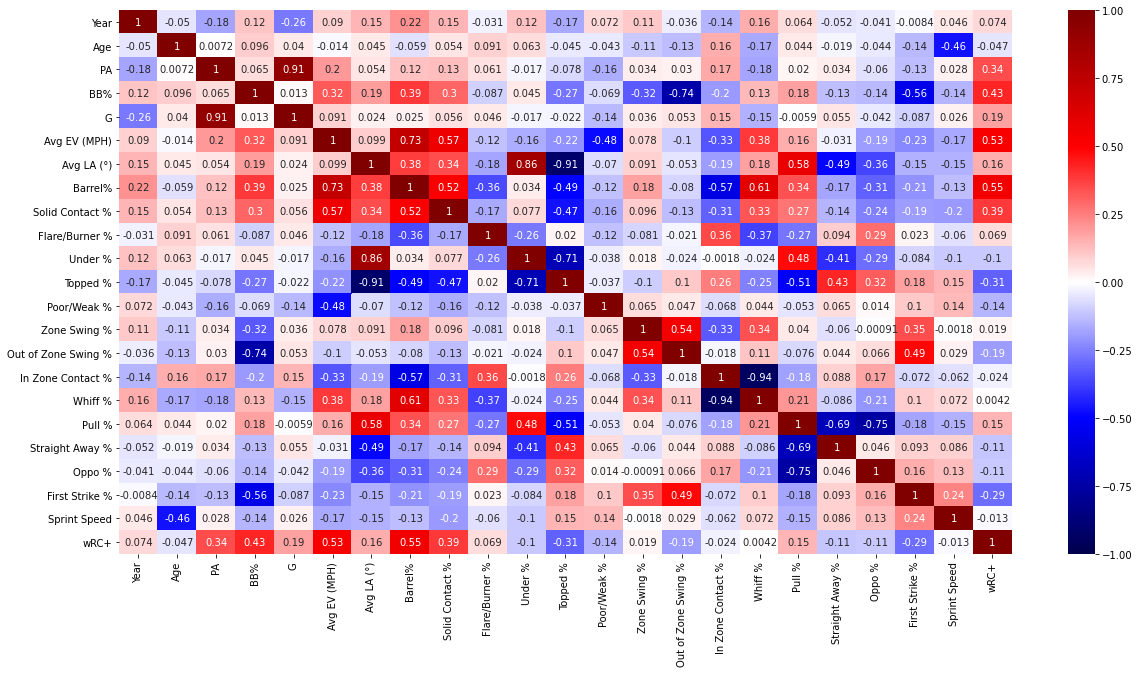

In [53]:
sns.heatmap(combined_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

BB Rate has a pretty strong relationship (relatively) to wRC+.

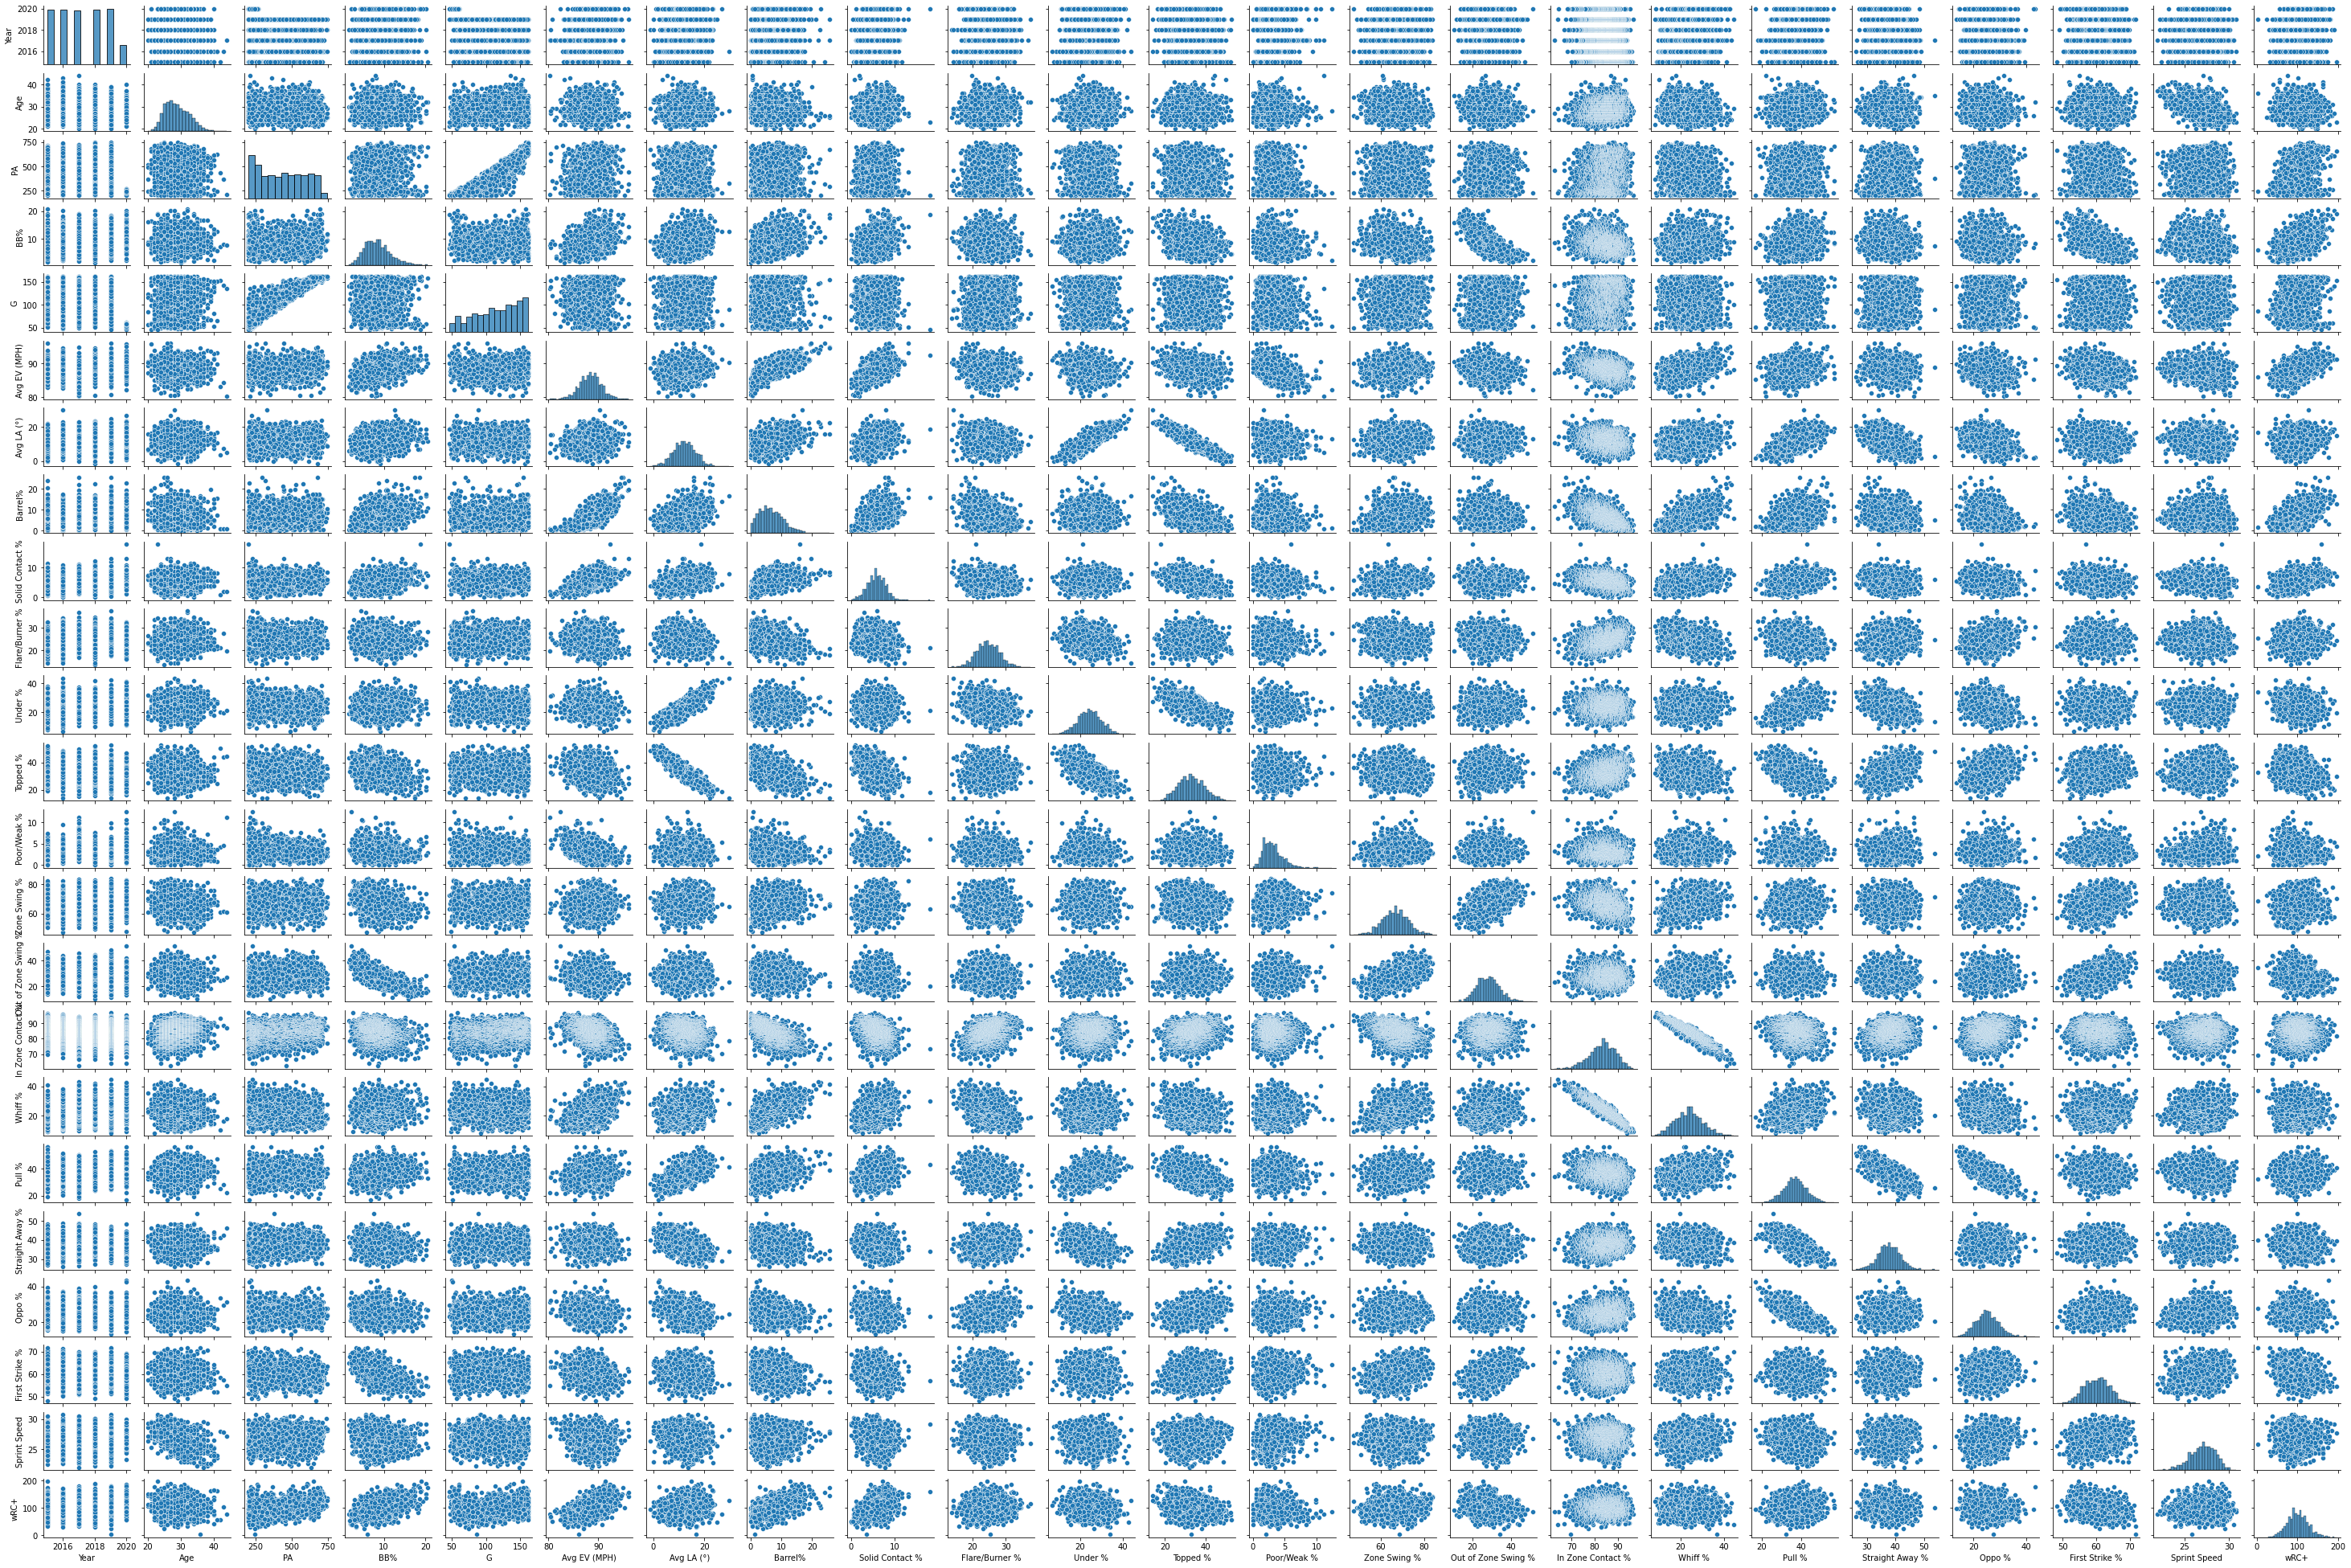

In [54]:
sns.pairplot(combined_df, height=1.2, aspect=1.5);

## Getting Ready for Modeling:

In [153]:
combined_df.columns

Index(['Player', 'Year', 'Age', 'PA', 'K%', 'BB%', 'G', 'Avg EV (MPH)',
       'Avg LA (°)', 'Barrel%', 'Solid Contact %', 'Flare/Burner %', 'Under %',
       'Topped %', 'Poor/Weak %', 'Zone Swing %', 'Out of Zone Swing %',
       'In Zone Contact %', 'Whiff %', 'Pull %', 'Straight Away %', 'Oppo %',
       'First Strike %', 'Sprint Speed', 'wRC+'],
      dtype='object')

In [154]:
columns = ['Age','K%','BB%','Avg EV (MPH)','Avg LA (°)','Barrel%','Solid Contact %',
          'Flare/Burner %','Under %','Topped %','Poor/Weak %','Zone Swing %', 'Out of Zone Swing %','In Zone Contact %','Whiff %','Pull %',
          'Straight Away %','Sprint Speed', 'Oppo %', 'First Strike %']

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [156]:
X,y = combined_df[columns], combined_df['wRC+']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=5)

## No Cross Validation:

Dividing train/val sets into individual sets:

In [157]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=12)

### Simple Linear Regression:

In [158]:
lm = LinearRegression()

In [159]:
lm.fit(X_train, y_train)
print(f'Simple Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

Simple Linear Regression val R^2: 0.679


In [160]:
list(zip(columns, lm.coef_))

[('Age', -0.35617410544131556),
 ('K%', -2.3618014846218403),
 ('BB%', 2.465307574782534),
 ('Avg EV (MPH)', 1.2101222307719692),
 ('Avg LA (°)', 0.03931521848096222),
 ('Barrel%', 3.7911781004029756),
 ('Solid Contact %', 1.0914461641007445),
 ('Flare/Burner %', 1.0124072333083975),
 ('Under %', -1.0778372496806818),
 ('Topped %', -0.7977560404468587),
 ('Poor/Weak %', 0.0281342514954355),
 ('Zone Swing %', -0.04275011644443638),
 ('Out of Zone Swing %', 0.37967595823379724),
 ('In Zone Contact %', -0.6288511222299623),
 ('Whiff %', -0.6602568445626755),
 ('Pull %', 3.245027903286367),
 ('Straight Away %', 2.9499283935239804),
 ('Sprint Speed', 3.553984861872813),
 ('Oppo %', 3.1591038851062856),
 ('First Strike %', 0.14507026764857972)]

### Polynomial Regression (degrees 2-4):

In [161]:
#From Degree 2 to 6
degrees = [2,3,4]
for n in degrees:
    poly = PolynomialFeatures(degree=n) 

    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)

    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    print(f'Degree polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Degree polynomial regression val R^2: 0.635
Degree polynomial regression val R^2: -4.861
Degree polynomial regression val R^2: -2.301


Worse than simple linear.

In [162]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

## With Cross Validation:

In [163]:
from sklearn.model_selection import KFold

In [164]:
X_cv, y_cv = np.array(X_train_val), np.array(y_train_val)

### Simple Linear, and Poly using KFOLD:

In [165]:
kf = KFold(n_splits=5, shuffle=True, random_state = 12)
cv_lm_r2s, cv_lm_poly_2 = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X_cv,y_cv):
    
    X_train, y_train = X_cv[train_ind], y_cv[train_ind]
    X_val, y_val = X_cv[val_ind], y_cv[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #2 Degree Polynomial:
    poly = PolynomialFeatures(degree=2) 

    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    
    cv_lm_poly_2.append(lm_poly.score(X_val_poly, y_val))

print('Simple regression scores: ', cv_lm_r2s, '\n')
print('Poly (2) scores: ', cv_lm_poly_2, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Poly (2) mean cv r^2: {np.mean(cv_lm_poly_2):.3f} +- {np.std(cv_lm_poly_2):.3f}')

Simple regression scores:  [0.6891256321692394, 0.6678391095245405, 0.6223039281408493, 0.6953028165866729, 0.6940607079384448] 

Poly (2) scores:  [0.6528173796943608, 0.604575128208747, 0.5566042796456171, 0.6099743722730038, 0.6476548038844109] 

Simple mean cv r^2: 0.674 +- 0.028
Poly (2) mean cv r^2: 0.614 +- 0.035


**Simple LR w/ KFold is the winner so far, best I've had in any model.  On to the next:**

### Lasso:

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score

In [167]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [168]:
columns

['Age',
 'K%',
 'BB%',
 'Avg EV (MPH)',
 'Avg LA (°)',
 'Barrel%',
 'Solid Contact %',
 'Flare/Burner %',
 'Under %',
 'Topped %',
 'Poor/Weak %',
 'Zone Swing %',
 'Out of Zone Swing %',
 'In Zone Contact %',
 'Whiff %',
 'Pull %',
 'Straight Away %',
 'Sprint Speed',
 'Oppo %',
 'First Strike %']

In [169]:
X = combined_df[columns]
y = combined_df['wRC+']

In [170]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=5)

In [171]:
std = StandardScaler()
std.fit(X_train_val.values)

StandardScaler()

In [172]:
X_tr = std.transform(X_train_val.values)

In [173]:
X_te = std.transform(X_test.values)

In [174]:
#alphavec = 10**np.linspace(-3,3,10000)

#lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model = LassoCV(cv= 5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(cv=5)

In [175]:
lasso_model.alpha_

0.04986002571434731

In [176]:
list(zip(X.columns, lasso_model.coef_))

[('Age', -1.2538598869375488),
 ('K%', -13.394176365082583),
 ('BB%', 6.733902959423776),
 ('Avg EV (MPH)', 1.990586639150285),
 ('Avg LA (°)', 0.0),
 ('Barrel%', 16.00782830437093),
 ('Solid Contact %', 2.823188377937765),
 ('Flare/Burner %', 3.536864830046968),
 ('Under %', -5.261820783403634),
 ('Topped %', -4.131168699344228),
 ('Poor/Weak %', 0.2989626496176952),
 ('Zone Swing %', -0.10588423802502753),
 ('Out of Zone Swing %', 1.5529645205690301),
 ('In Zone Contact %', -3.0692597752387383),
 ('Whiff %', -4.1513651911143645),
 ('Pull %', 0.5984768960559455),
 ('Straight Away %', -0.9729604839213115),
 ('Sprint Speed', 5.022485459311922),
 ('Oppo %', -0.0),
 ('First Strike %', 0.36738332034819426)]

Based on the features, it seems that barrel rate and in zone contact rate are the most correlated in the position direction.

In [177]:
lasso_model.intercept_

101.33883751651254

Intercept matches up, 101 is just above league average wRC+ of 100.

In [178]:
train_val_pred = lasso_model.predict(X_tr)

In [179]:
mae(y_train_val, train_val_pred)

11.43303894050308

In [180]:
r2_score(y_train_val, train_val_pred)

0.6846504194299349

New winner! previous value in New Stats - Modeling.ipynb was 0.56065....

## Ridge Regression Model

In [181]:
X_train_val.shape, X_test.shape

((1514, 20), (379, 20))

In [182]:
X_tr = std.transform(X_train_val.values)

In [183]:
X_te = std.transform(X_test.values)

In [184]:
#alphavec = 10**np.linspace(-3,3,10000)

#ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model = RidgeCV(cv=5)

ridge_model.fit(X_tr, y_train_val)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5)

In [185]:
ridge_model.alpha_

10.0

In [186]:
list(zip(X_train_val.columns, ridge_model.coef_))

[('Age', -1.2755305311218643),
 ('K%', -13.095833334812088),
 ('BB%', 6.88757859630381),
 ('Avg EV (MPH)', 2.5237584124279517),
 ('Avg LA (°)', 0.6575660310630788),
 ('Barrel%', 15.294183687523583),
 ('Solid Contact %', 2.684544812253964),
 ('Flare/Burner %', 3.353256928009896),
 ('Under %', -5.880752735975771),
 ('Topped %', -4.22358070856313),
 ('Poor/Weak %', 0.47837924311509467),
 ('Zone Swing %', -0.19435169626851145),
 ('Out of Zone Swing %', 1.8070067278492568),
 ('In Zone Contact %', -3.556534880941356),
 ('Whiff %', -4.897259027601831),
 ('Pull %', 0.7300814414889338),
 ('Straight Away %', -0.9331743301499824),
 ('Sprint Speed', 5.0077511126347884),
 ('Oppo %', 0.037868034015163136),
 ('First Strike %', 0.44089718723378385)]

In [187]:
ridge_model.intercept_

101.33883751651254

Scoring on Train/Val:

In [188]:
ridge_train_set_pred = ridge_model.predict(X_tr)

In [189]:
mae(y_train_val, ridge_train_set_pred)

11.429949016100075

In [190]:
r2_score(y_train_val, ridge_train_set_pred)

0.6848079616320294

Slighly worse than Lasso.

## Elastic Net Model

In [191]:
X_train_val.shape, X_test.shape

((1514, 20), (379, 20))

In [192]:
X_tr = std.transform(X_train_val.values)
X_te = std.transform(X_test.values)

In [193]:
#alphavec = 10**np.linspace(-3,3,10000)

#en_model = ElasticNetCV(alphas = alphavec, cv=5)
en_model = ElasticNetCV(cv=5)
en_model.fit(X_tr, y_train_val)

ElasticNetCV(cv=5)

In [194]:
en_model.alpha_

0.028400628327118517

In [195]:
list(zip(X_train_val.columns, en_model.coef_))

[('Age', -1.2840980733504286),
 ('K%', -12.664045053840944),
 ('BB%', 6.780842930741161),
 ('Avg EV (MPH)', 2.7781388643094025),
 ('Avg LA (°)', 0.6086109305597696),
 ('Barrel%', 14.815009653125495),
 ('Solid Contact %', 2.609954734937931),
 ('Flare/Burner %', 3.221382936823574),
 ('Under %', -5.806127273295746),
 ('Topped %', -4.311529403371086),
 ('Poor/Weak %', 0.5071012232501713),
 ('Zone Swing %', -0.0),
 ('Out of Zone Swing %', 1.595481226155117),
 ('In Zone Contact %', -2.827311351621437),
 ('Whiff %', -4.396944642699198),
 ('Pull %', 0.6271706995213358),
 ('Straight Away %', -0.9644276212658033),
 ('Sprint Speed', 4.895408249199247),
 ('Oppo %', -0.0),
 ('First Strike %', 0.35057436633015016)]

In [196]:
en_model.intercept_

101.33883751651254

Scoring on validation set:

In [197]:
en_val_set_pred = en_model.predict(X_tr)

In [198]:
mae(y_train_val, en_val_set_pred)

11.449574362913111

In [199]:
r2_score(y_train_val, en_val_set_pred)

0.6841552291118242

SLightly worse than Ridge and Lasso.

## Running Lasso with Polynomial Features

In [200]:
m = LassoCV(cv=5)
p = PolynomialFeatures(degree=2)

X_train_poly = p.fit_transform(X_train_val)

s = StandardScaler(with_mean=False)
X_train_val_poly_scaled = s.fit_transform(X_train_poly)

m.fit(X_train_val_poly_scaled,y_train_val)
m.score(X_train_val_poly_scaled,y_train_val)

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.84127584801172, tolerance: 81.18815375722546
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259.92079886829015, tolerance: 81.18815375722546
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521.2291606616054, tolerance: 81.18815375722546
  model = cd_fast.enet_coordinate_descent_gram(

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 739.425456649682, tolerance: 78.18059355904212
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1052.31254876178, tolerance: 78.18059355904212
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1642.0561676030047, tolerance: 78.18059355904212
  model = cd_fast.enet_coordinate_descent_gram(
/U

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250.22031078921282, tolerance: 79.6368761551155
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328.4878473256831, tolerance: 79.6368761551155
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348.2578017745109, tolerance: 79.6368761551155
  model = cd_fast.enet_coordinate_descent_gram(
/Us

0.6976170387320357

In [201]:
m.alpha_

0.15442781219656465

In [202]:
lasso_poly_train_set_pred = m.predict(X_train_val_poly_scaled)

In [203]:
mae(y_train_val, lasso_poly_train_set_pred)

11.18274275788451

In [204]:
r2_score(y_train_val, lasso_poly_train_set_pred)

0.6976170387320357

In [205]:
list(zip(p.get_feature_names(), m.coef_))

[('1', 0.0),
 ('x0', -0.0),
 ('x1', -0.0),
 ('x2', 0.0),
 ('x3', 0.0),
 ('x4', 0.0),
 ('x5', 0.0),
 ('x6', 0.0),
 ('x7', 0.0),
 ('x8', -0.0),
 ('x9', -0.0),
 ('x10', -0.0),
 ('x11', -0.0),
 ('x12', -0.0),
 ('x13', -0.0),
 ('x14', -0.0),
 ('x15', 0.0),
 ('x16', -0.0),
 ('x17', 0.0),
 ('x18', 0.0),
 ('x19', -0.0),
 ('x0^2', -0.0),
 ('x0 x1', -0.15540927214295067),
 ('x0 x2', 0.0),
 ('x0 x3', -0.0),
 ('x0 x4', -0.0),
 ('x0 x5', 0.0),
 ('x0 x6', 0.0),
 ('x0 x7', -0.0),
 ('x0 x8', -0.0),
 ('x0 x9', -0.0),
 ('x0 x10', 0.0),
 ('x0 x11', -0.0),
 ('x0 x12', -0.0),
 ('x0 x13', -0.900062846257029),
 ('x0 x14', -0.0),
 ('x0 x15', -0.0),
 ('x0 x16', -0.5561198110891412),
 ('x0 x17', -0.0),
 ('x0 x18', -0.0),
 ('x0 x19', -0.0),
 ('x1^2', -5.875965689595985),
 ('x1 x2', -0.0),
 ('x1 x3', -0.0),
 ('x1 x4', -0.0),
 ('x1 x5', -0.0),
 ('x1 x6', -0.0),
 ('x1 x7', -0.0),
 ('x1 x8', -0.0),
 ('x1 x9', -0.0),
 ('x1 x10', -0.5756838841236178),
 ('x1 x11', -1.259870270726047),
 ('x1 x12', -0.0),
 ('x1 x13', -4.

In [206]:
X_train_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1514 entries, 1883 to 867
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1514 non-null   int64  
 1   K%                   1514 non-null   float64
 2   BB%                  1514 non-null   float64
 3   Avg EV (MPH)         1514 non-null   float64
 4   Avg LA (°)           1514 non-null   float64
 5   Barrel%              1514 non-null   float64
 6   Solid Contact %      1514 non-null   float64
 7   Flare/Burner %       1514 non-null   float64
 8   Under %              1514 non-null   float64
 9   Topped %             1514 non-null   float64
 10  Poor/Weak %          1514 non-null   float64
 11  Zone Swing %         1514 non-null   float64
 12  Out of Zone Swing %  1514 non-null   float64
 13  In Zone Contact %    1514 non-null   float64
 14  Whiff %              1514 non-null   float64
 15  Pull %               1514 non-null  

 ('x2 x18', 5.136694660948854) #Avg EV * SPrint Speed  
('x4 x15', 6.0399998242563075) #Barrel % * Straight Away %  
('x12 x13', -6.538302723785151), #IN zone contact * Whiff %  
('x13^2', -6.7601579817100825), #Whiff %^2  
'x1 x11', 3.0734475598431295) BB%*OUt of Zone Swing Rate*
('x4 x8', 2.985381941312241), Barrel*Out of zone swing
('x4 x12', 4.754249915766434) #barrel%*in zone contact*
('x8 x12', -3.4788440522742548) topped*inzonecontact

### Trying Lasso with Above Interactions:

### Lasso:

In [209]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score

In [210]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [211]:
columns

['Age',
 'K%',
 'BB%',
 'Avg EV (MPH)',
 'Avg LA (°)',
 'Barrel%',
 'Solid Contact %',
 'Flare/Burner %',
 'Under %',
 'Topped %',
 'Poor/Weak %',
 'Zone Swing %',
 'Out of Zone Swing %',
 'In Zone Contact %',
 'Whiff %',
 'Pull %',
 'Straight Away %',
 'Sprint Speed',
 'Oppo %',
 'First Strike %']

In [212]:
X = combined_df[columns]
y = combined_df['wRC+']

Adding Interactions:

 ('x2 x18', 5.136694660948854) #Avg EV * SPrint Speed  
('x4 x15', 6.0399998242563075) #Barrel % * Straight Away %  
('x12 x13', -6.538302723785151), #IN zone contact * Whiff %  
('x13^2', -6.7601579817100825), #Whiff %^2  
'x1 x11', 3.0734475598431295) BB%*OUt of Zone Swing Rate*  
('x4 x8', 2.985381941312241), Barrel*Out of zone swing  
('x4 x12', 4.754249915766434) #barrel%*in zone contact*  
('x8 x12', -3.4788440522742548) topped*inzonecontact  

X['EV*Speed'] = X['Avg EV (MPH)'] * X['Sprint Speed']
X['Barrel*StraightAway'] = X['Barrel%'] * X['Straight Away %']
X['InZoneContact*Whiff'] = X['In Zone Contact %'] * X['Whiff %']
X['Whiff^2'] = X['Whiff %']**2
X['BB-OutOfZone'] = X['BB%'] * X['Out of Zone Swing %']
X['Barrel-OutOfZone'] = X['Barrel%'] * X['Out of Zone Swing %']
X['Barrel-InZone'] = X['Barrel%'] * X['In Zone Contact %']
X['Topped-InZone'] = X['Topped %'] * X['In Zone Contact %']

In [213]:
X.head()

Age    K%  BB%  Avg EV (MPH)  Avg LA (°)  Barrel%  Solid Contact %  \
0   28  13.0  2.2          82.3        13.2      1.0              3.1   
1   26  33.1  4.7          90.8         4.7     11.5              6.8   
2   29  14.5  5.0          88.1        10.0      4.8              4.0   
3   30  13.8  2.8          86.4        14.1      4.9              5.7   
4   30  32.7  3.9          87.9        16.2      6.6              6.6   

   Flare/Burner %  Under %  Topped %  Poor/Weak %  Zone Swing %  \
0            27.5     22.8      32.1         12.4          74.2   
1            24.4     13.6      40.9          2.9          79.6   
2            21.0     25.3      40.0          3.0          74.5   
3            22.7     28.0      33.5          4.3          73.0   
4            19.9     30.8      32.2          2.8          78.4   

   Out of Zone Swing %  In Zone Contact %  Whiff %  Pull %  Straight Away %  \
0                 51.3               88.7     17.1    35.8             40.4   
1                 48.1               72.8     38.4    27.6             40.9   
2                 47.0               84.6     19.2    30.0             41.0   
3                 46.9               90.9     17.8    45.2             32.1   
4                 45.9               73.5     35.7    42.7             37.0   

   Sprint Speed  Oppo %  First Strike %  
0          26.8    23.8            64.1  
1          28.8    31.5            63.2  
2          24.7    29.0            65.0  
3          28.0    22.7            64.5  
4          26.6    20.4            71.2

In [214]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=5)

In [215]:
std = StandardScaler()
std.fit(X_train_val.values)

StandardScaler()

In [216]:
X_tr = std.transform(X_train_val.values)

In [217]:
X_te = std.transform(X_test.values)

In [219]:
alphavec = np.linspace(0,100)

lasso_int_model = LassoCV(alphas = alphavec, cv=5)
#lasso_int_model = LassoCV(cv= 5)
lasso_int_model.fit(X_tr, y_train_val)

/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123011.94094103226, tolerance: 81.18815375722546
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/patrickbovard/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: Convergen

LassoCV(alphas=array([  0.        ,   2.04081633,   4.08163265,   6.12244898,
         8.16326531,  10.20408163,  12.24489796,  14.28571429,
        16.32653061,  18.36734694,  20.40816327,  22.44897959,
        24.48979592,  26.53061224,  28.57142857,  30.6122449 ,
        32.65306122,  34.69387755,  36.73469388,  38.7755102 ,
        40.81632653,  42.85714286,  44.89795918,  46.93877551,
        48.97959184,  51.02040816,  53.06122449,  55.10204082,
        57.14285714,  59.18367347,  61.2244898 ,  63.26530612,
        65.30612245,  67.34693878,  69.3877551 ,  71.42857143,
        73.46938776,  75.51020408,  77.55102041,  79.59183673,
        81.63265306,  83.67346939,  85.71428571,  87.75510204,
        89.79591837,  91.83673469,  93.87755102,  95.91836735,
        97.95918367, 100.        ]),
        cv=5)

In [220]:
lasso_int_model.alpha_

0.0

In [221]:
list(zip(X.columns, lasso_int_model.coef_))

[('Age', -1.2622439293634582),
 ('K%', -13.461320207517641),
 ('BB%', 6.93340996887432),
 ('Avg EV (MPH)', 2.205004881607175),
 ('Avg LA (°)', 0.5088495925801253),
 ('Barrel%', 15.845250272200404),
 ('Solid Contact %', 2.787229320885066),
 ('Flare/Burner %', 3.512228579852243),
 ('Under %', -5.752783882151324),
 ('Topped %', -4.113968773723866),
 ('Poor/Weak %', 0.41851883331602224),
 ('Zone Swing %', -0.34133790040354517),
 ('Out of Zone Swing %', 1.9368235785276842),
 ('In Zone Contact %', -4.090258196804663),
 ('Whiff %', -5.219931796369157),
 ('Pull %', 1.8750318000601665),
 ('Straight Away %', -0.2019677418054409),
 ('Sprint Speed', 5.097092714089029),
 ('Oppo %', 0.8569837828365301),
 ('First Strike %', 0.4930207088722826)]

Based on the features, it seems that barrel rate and in zone contact rate are the most correlated in the position direction.

In [222]:
lasso_int_model.intercept_

101.33883751651254

Intercept matches up, 101 is just above league average wRC+ of 100.

In [223]:
train_val_pred = lasso_int_model.predict(X_tr)

In [224]:
mae(y_train_val, train_val_pred)

11.422126482043712

In [225]:
r2_score(y_train_val, train_val_pred)

0.6849747693930535

Didn't siginicantly increase the original Lasso R^2 value (0.6313804374539747)

## Of all the models, Lasso performed the best on train/val. 

### This is the same result as last time, with Lasso performing best.  However, it looks like the change in terms has boosted r^2 as I thought would happen.

Let's look at the test set:

In [353]:
test_set_pred = lasso_model.predict(X_te)

In [354]:
mae(y_test, test_set_pred)

11.861447598729766

Within this use case, being off by 13.14 is basically saying on average, you could predict someone to be 13% above or below league average, when they are a league average player.  Not awful.

In [355]:
r2_score(y_test, test_set_pred)

0.6523903424047806

Residual Plot:

Text(0.5, 1.0, 'LASSO Regression Model: wRC+')

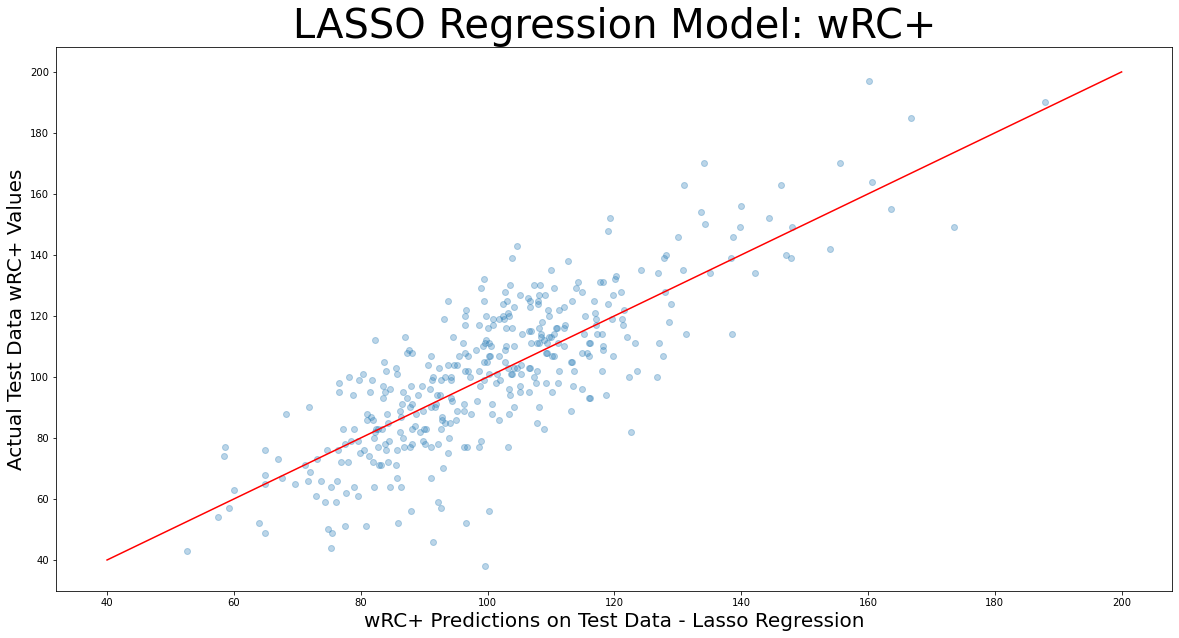

In [356]:
plt.scatter(test_set_pred, y_test, alpha=.3)
plt.plot(np.linspace(40,200), np.linspace(40,200), color='red')
plt.xlabel('wRC+ Predictions on Test Data - Lasso Regression', size=20)
plt.ylabel('Actual Test Data wRC+ Values', size=20)
plt.title('LASSO Regression Model: wRC+', size=40)

In [357]:
X_new = std.transform(combined_df[columns])

In [358]:
combined_df['prediction'] = lasso_model.predict(X_new)

In [359]:
combined_df['residual'] = combined_df['wRC+'] - combined_df.prediction

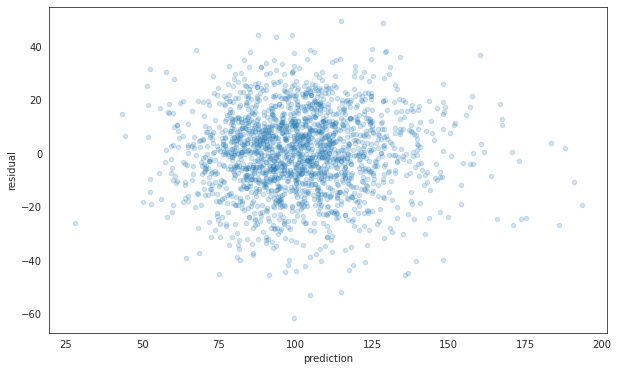

In [360]:
with sns.axes_style('white'):
    plot=combined_df.plot(kind='scatter',
                  x='prediction',y='residual',alpha=0.2,figsize=(10,6))

Looking at under predictions:

In [364]:
combined_df.sort_values(by='residual', ascending=False).head(10)

Player  Year  Age   PA   BB%    G  Avg EV (MPH)  \
1571         Cruz, Nelson  2020   40  214  11.7   53          91.6   
52           LeMahieu, DJ  2020   32  216   8.3   50          91.3   
1789     Colabello, Chris  2015   32  360   6.1  101          90.0   
762    Hernandez, Enrique  2015   24  218   5.0   76          90.4   
1069       Blanco, Andres  2015   31  261   8.0  106          87.1   
1806          Olson, Matt  2017   23  216  10.2   59          92.2   
1227      Suarez, Eugenio  2015   24  398   4.3   97          88.5   
1654        Anderson, Tim  2020   27  221   4.5   49          87.2   
214         Bregman, Alex  2019   25  690  17.2  156          89.3   
485      Gonzalez, Marwin  2017   28  515   9.5  134          88.6   

      Avg LA (°)  Barrel%  Solid Contact %  ...  In Zone Contact %  Whiff %  \
1571         9.4     15.0              3.9  ...               78.0     34.2   
52           2.3      2.9              9.1  ...               92.9     11.2   
1789         9.8      9.2              5.0  ...               73.8     31.2   
762         11.0      5.0              6.3  ...               84.9     26.5   
1069        10.6      5.2              4.7  ...               82.8     22.1   
1806        17.4     16.3              6.2  ...               73.1     32.0   
1227        14.9      5.3              4.2  ...               81.5     25.4   
1654         6.7     10.1              4.4  ...               76.8     30.9   
214         19.6      4.8              9.8  ...               90.0     14.3   
485         11.7      6.6              4.7  ...               87.2     20.4   

      Pull %  Straight Away %  Oppo %  First Strike %  Sprint Speed  wRC+  \
1571    29.1             43.3    27.6            55.6          25.2   164   
52      22.3             34.3    43.4            65.3          26.1   177   
1789    31.4             43.1    25.5            68.1          26.1   143   
762     40.3             37.1    22.6            55.5          27.2   132   
1069    33.9             41.1    25.0            61.7          26.8   137   
1806    48.8             28.7    22.5            56.9          24.3   164   
1227    37.3             37.3    25.4            65.3          27.0   106   
1654    29.6             48.4    22.0            63.3          28.7   143   
214     42.8             39.2    18.0            55.2          27.4   168   
485     35.5             39.1    25.5            56.4          26.7   144   

      prediction   residual  
1571  114.739235  49.260765  
52    128.497405  48.502595  
1789   98.890895  44.109105  
762    87.921372  44.078628  
1069   93.549813  43.450187  
1806  125.063080  38.936920  
1227   67.570798  38.429202  
1654  104.596109  38.403891  
214   129.606582  38.393418  
485   106.032668  37.967332  

[10 rows x 26 columns]

Guys with high walk rates are gone, with the remaining being BABIP outliers

BABIP on above:

- Nelson Cruz 2020: .360
- LaMahieu 2020: BABIP of .370 - that is extremely high.  Won the AL Batting Title in 2020.
- Chris Colabello 2015: .411 BABIP, which is insane.
- Enrique Hernandez 2015: .359
- Andres Blanco 2015: .335
- Tim Anderson 2020: .383 BABIP
- Bregman 2019: BABIP of .281, that's not that odd, and even unlucky.  Walk rate of 17.2% - no. 3 in baseball in 2019. Finished second in 2019 MVP voting.
- Suarez: .341 BABIP

And Over predictions:

In [371]:
combined_df.sort_values(by='residual', ascending=True).head(10)

Player  Year  Age   PA   BB%    G  Avg EV (MPH)  Avg LA (°)  \
1451      Reyes, Victor  2018   24  219   2.3  100          85.4         6.2   
732         Uribe, Juan  2016   37  259   5.8   73          88.1        10.1   
386    Morales, Kendrys  2019   36  201  12.9   53          91.3         9.5   
1564    Schwarber, Kyle  2020   27  224  13.4   59          92.8         8.8   
12            Shuck, JB  2016   29  241   5.0   80          84.9         7.5   
1061         Gomes, Yan  2016   29  264   3.4   74          87.0        16.8   
916     Cabrera, Miguel  2017   34  529  10.2  130          91.3        12.5   
773       Owings, Chris  2018   27  309   7.8  106          87.8        13.4   
504    Escobar, Eduardo  2020   31  222   6.8   54          88.6        18.1   
1599     Altherr, Aaron  2018   27  285  12.6  105          90.4        10.2   

      Barrel%  Solid Contact %  ...  In Zone Contact %  Whiff %  Pull %  \
1451      3.0              3.6  ...               79.4     22.1    28.0   
732       7.3              5.7  ...               85.2     21.1    36.5   
386       6.9              6.2  ...               88.2     17.9    37.9   
1564     11.2              8.8  ...               78.1     28.2    44.8   
12        1.9              1.4  ...               94.7     10.3    34.8   
1061      5.4              8.2  ...               82.8     25.0    37.5   
916      10.5             10.8  ...               83.9     23.1    27.6   
773       5.8              6.3  ...               84.8     24.6    31.7   
504       5.5              3.7  ...               87.1     21.6    40.2   
1599      9.7             10.4  ...               77.5     32.8    38.3   

      Straight Away %  Oppo %  First Strike %  Sprint Speed  wRC+  prediction  \
1451             41.1    31.0            69.4          29.2    38   99.622636   
732              43.8    19.8            61.0          25.5    52  104.883826   
386              38.6    23.4            57.2          23.5    63  114.727478   
1564             36.0    19.2            52.2          26.9    90  135.725430   
12               40.1    25.1            61.0          28.9    46   91.385572   
1061             37.5    25.0            64.8          26.6    30   75.001898   
916              39.2    33.1            60.7          24.9    92  136.719529   
773              38.0    30.3            59.5          28.3    52   96.538489   
504              36.0    23.8            64.0          28.0    56  100.238055   
1599             38.3    23.4            59.3          29.0    74  117.582748   

       residual  
1451 -61.622636  
732  -52.883826  
386  -51.727478  
1564 -45.725430  
12   -45.385572  
1061 -45.001898  
916  -44.719529  
773  -44.538489  
504  -44.238055  
1599 -43.582748  

[10 rows x 26 columns]

In [523]:
combined_df[abs(combined_df['residual']) >= 40]

Player  Year  Age   PA   BB%    G  Avg EV (MPH)  \
12              Shuck, JB  2016   29  241   5.0   80          84.9   
52           LeMahieu, DJ  2020   32  216   8.3   50          91.3   
386      Morales, Kendrys  2019   36  201  12.9   53          91.3   
504      Escobar, Eduardo  2020   31  222   6.8   54          88.6   
732           Uribe, Juan  2016   37  259   5.8   73          88.1   
760         Kim, Hyun Soo  2017   29  239   9.2   96          88.7   
762    Hernandez, Enrique  2015   24  218   5.0   76          90.4   
773         Owings, Chris  2018   27  309   7.8  106          87.8   
849         Jansen, Danny  2019   24  384   8.1  107          88.9   
916       Cabrera, Miguel  2017   34  529  10.2  130          91.3   
1048        Odor, Rougned  2017   23  651   4.9  162          89.1   
1061           Gomes, Yan  2016   29  264   3.4   74          87.0   
1069       Blanco, Andres  2015   31  261   8.0  106          87.1   
1406        Odor, Rougned  2019   25  581   9.0  145          91.1   
1451        Reyes, Victor  2018   24  219   2.3  100          85.4   
1564      Schwarber, Kyle  2020   27  224  13.4   59          92.8   
1571         Cruz, Nelson  2020   40  214  11.7   53          91.6   
1599       Altherr, Aaron  2018   27  285  12.6  105          90.4   
1789     Colabello, Chris  2015   32  360   6.1  101          90.0   
1811          Avila, Alex  2015   28  219  18.3   67          91.2   
1862         Sano, Miguel  2020   27  205   8.8   53          95.2   
1881          Gallo, Joey  2018   25  577  12.8  148          94.3   

      Avg LA (°)  Barrel%  Solid Contact %  ...  In Zone Contact %  Whiff %  \
12           7.5      1.9              1.4  ...               94.7     10.3   
52           2.3      2.9              9.1  ...               92.9     11.2   
386          9.5      6.9              6.2  ...               88.2     17.9   
504         18.1      5.5              3.7  ...               87.1     21.6   
732         10.1      7.3              5.7  ...               85.2     21.1   
760          9.7      3.6              5.4  ...               84.9     18.6   
762         11.0      5.0              6.3  ...               84.9     26.5   
773         13.4      5.8              6.3  ...               84.8     24.6   
849         16.3      5.9              5.6  ...               84.3     20.5   
916         12.5     10.5             10.8  ...               83.9     23.1   
1048        15.8      6.0              8.2  ...               82.9     26.0   
1061        16.8      5.4              8.2  ...               82.8     25.0   
1069        10.6      5.2              4.7  ...               82.8     22.1   
1406        17.9     13.6              6.4  ...               79.9     29.4   
1451         6.2      3.0              3.6  ...               79.4     22.1   
1564         8.8     11.2              8.8  ...               78.1     28.2   
1571         9.4     15.0              3.9  ...               78.0     34.2   
1599        10.2      9.7             10.4  ...               77.5     32.8   
1789         9.8      9.2              5.0  ...               73.8     31.2   
1811        13.2     10.6              8.8  ...               73.0     35.8   
1862        20.2     22.9              9.4  ...               70.6     42.6   
1881        21.9     22.5              7.8  ...               68.4     41.0   

      Pull %  Straight Away %  Oppo %  First Strike %  Sprint Speed  wRC+  \
12      34.8             40.1    25.1            61.0          28.9    46   
52      22.3             34.3    43.4            65.3          26.1   177   
386     37.9             38.6    23.4            57.2          23.5    63   
504     40.2             36.0    23.8            64.0          28.0    56   
732     36.5             43.8    19.8            61.0          25.5    52   
760     31.5             39.3    29.2            53.1          26.3    61   
762     40.3             37.1    22.6            55

Text(0.5, 1.0, 'LASSO Regression Model: wRC+')

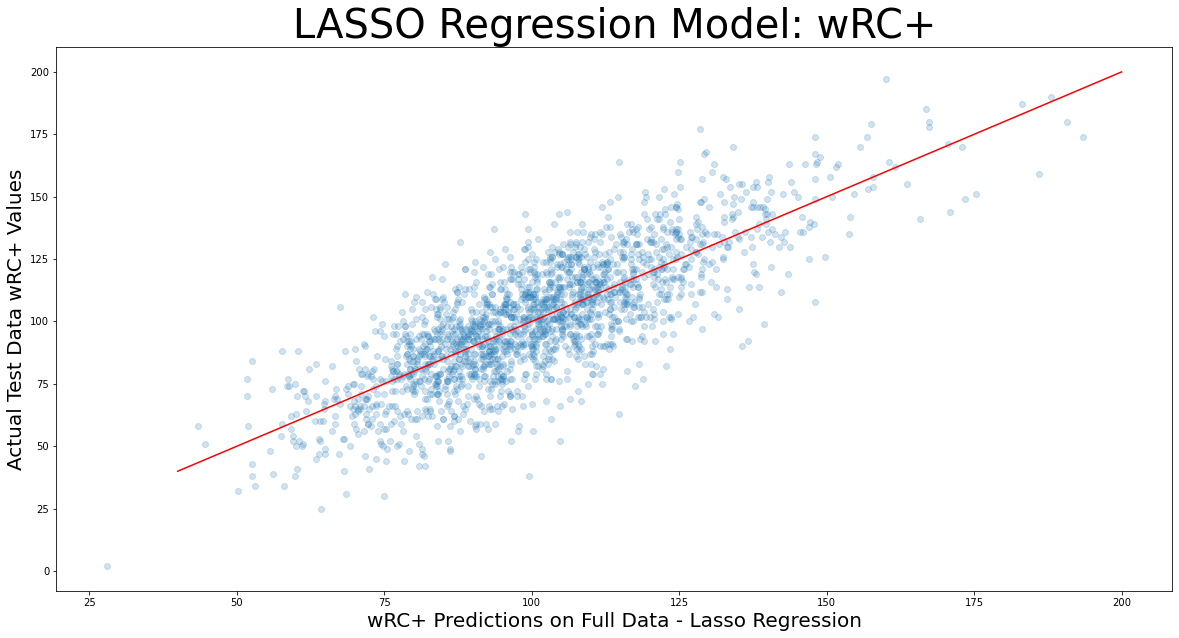

In [373]:
plt.scatter(combined_df['prediction'], combined_df['wRC+'], alpha=.2)
plt.plot(np.linspace(40,200), np.linspace(40,200), color='red')
plt.xlabel('wRC+ Predictions on Full Data - Lasso Regression', size=20)
plt.ylabel('Actual Test Data wRC+ Values', size=20)
plt.title('LASSO Regression Model: wRC+', size=40)